# Chargement des libraires, atlas (parcelation), surfaces etc..

In [ ]:
import os
import glob
import pandas as pd 
import numpy as np
import math
#import plotnine as p9
import matplotlib.pyplot as plt
try :
    import seaborn as sns
except : 
    ! pip install seaborn
    import seaborn as sns
try :
    import nibabel as nib
except : 
    ! pip install nibabel
    import nibabel as nib

from skimage.util import montage 
from skimage.transform import rotate
try : 
    import openxyl
except : 
    ! pip install openpyxl

from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
#%matplotlib notebook
import laBIBILaRORO as lbr

try :
    from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
except : 
    ! pip install brainstat
    from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation

from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from IPython.display import display,Image
import statsmodels.api as sm
from brainstat.stats.terms import FixedEffect
from brainstat.stats.terms import MixedEffect
from brainstat.stats.SLM import SLM
import scipy.stats as stats
from scipy.stats import ttest_ind
import laBIBILaRORO as lbr

La bibil à RORO loaded


In [2]:
pial_left, pial_right = fetch_template_surface("fsaverage5",layer="pial",join=False)
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")
glasser = fetch_parcellation("fsaverage5", "glasser", 360)

pial_left_fslr32k, pial_right_fslr32k = fetch_template_surface("fslr32k", join=False)
inflated_left_fslr32k,inflated_right_fslr32k = fetch_template_surface("fslr32k",layer="inflated", join=False)
vinflated_left_fslr32k,vinflated_right_fslr32k = fetch_template_surface("fslr32k",layer="vinflated", join=False)
pial_combined_fslr32k = fetch_template_surface("fslr32k", join=True)
mask_fslr32k = fetch_mask("fslr32k")
glasser_fslr32k = fetch_parcellation("fslr32k", "glasser", 360)

In [3]:
file_path = '/NAS/tupac/romain/MNI_Glasser_extHCP_etc/HCP-MMP1_UniqueRegionList.csv'
df_exthcp = pd.read_csv(file_path)
#print(df_exthcp.head())  # Affiche les premières lignes du DataFrame

file_path = '/NAS/tupac/romain/MNI_Glasser_extHCP_etc/Glasser_2016_Table-1.xlsx'
df_gla = pd.read_excel(file_path)
#df_gla

#attention entre el numero de regionID et le numero dans numpy ndarray il y aun decalge de 20 l'un recommence à 181 l'autre à 200
#mapping_dict = dict(zip(df_exthcp['regionID'], df_exthcp['Cortex_ID']))
mapping_dict = dict(zip(df_exthcp.index.values+1, df_exthcp['Cortex_ID']))

mapping_dict[0] = 0
def map_values(value):
    return mapping_dict.get(value, 400)  # Remplacer 0 par une autre valeur par défaut si nécessaire

for key in mapping_dict.keys():
    # Vérifier si la clé est supérieure à 180
    if key > 180:
        # Ajouter 22 à la valeur correspondante
        mapping_dict[key] += 22

# Utiliser np.vectorize pour appliquer la fonction de correspondance
vectorized_map = np.vectorize(map_values)
glasser_fslr32k_exthcp = vectorized_map(glasser_fslr32k)

#verif 
#set(mapping_dict.values())

## Affiche des infos principales

In [4]:

print(f"number of points in fslr32k = {glasser_fslr32k.shape[0]}, left and right = {inflated_left_fslr32k.GetPoints().shape[0]}")
print(f"number of points in fsaverage = {glasser.shape[0]}, left and right = {inflated_right.GetPoints().shape[0]}")
print(f"number of ROI values in glasser = {len(np.unique(glasser))}")
print(f"number of ROI values in HCP extended = {len(np.unique(glasser_fslr32k_exthcp))}")

number of points in fslr32k = 64984, left and right = 32492
number of points in fsaverage = 20484, left and right = 10242
number of ROI values in glasser = 361
number of ROI values in HCP extended = 45


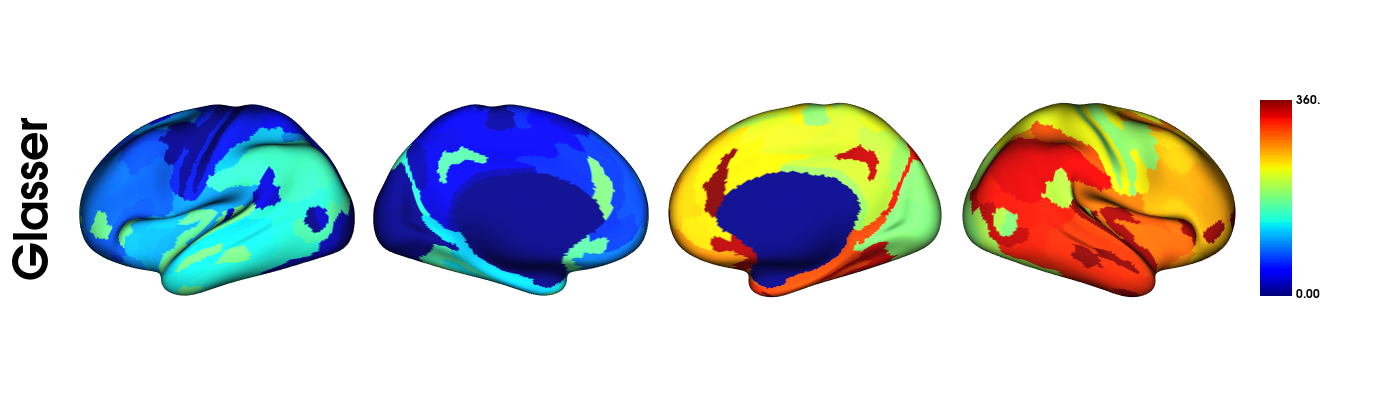

In [5]:
#np.where(np.isin(glasser_fslr32k, [1,4,5,6]),glasser_fslr32k, 0)
plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,glasser_fslr32k, color_bar=True,
        label_text=["Glasser"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

In [6]:
#np.where(np.isin(glasser_fslr32k, [1,2,3,4]),glasser_fslr32k, 0)
plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,glasser_fslr32k_exthcp, color_bar=True,
        label_text=["extended\nHCP"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

# Chargement des données propre à l'étude

In [7]:
STUDY_PATH=os.path.join("/NAS","dumbo","protocoles","FAIRPARKII")
SCRIPT_PATH=os.path.join(STUDY_PATH,'scripts')
LOG_PATH=os.path.join(SCRIPT_PATH,'log')
DATA_FILE=os.path.join(STUDY_PATH,"AdrianPiotto_M1",'DataAnxAP.xlsx')
CQ_FILE=os.path.join(STUDY_PATH,'FairparkII_MRIData_20210817.xlsx')

In [8]:
CQData = pd.read_excel(CQ_FILE,index_col=0,engine='openpyxl')
CLIData = pd.read_excel(DATA_FILE,index_col=0,engine='openpyxl')

In [9]:
# Filtrer les individus avec un score "MDS1 1.4" > 0
filtered_data = CLIData[CLIData['MDS 1.4'] > 0]
# Compter le nombre d'individus
count = filtered_data.shape[0]
print(f"Nombre d'individus avec un score de 'MDS1 1.4' > 0 : {count}")

Nombre d'individus avec un score de 'MDS1 1.4' > 0 : 114


In [10]:
CLIData['ANX'] = CLIData['MDS 1.4'].apply(lambda x: 1 if x > 0 else 0)
CLIData.index = CLIData.index.str.replace('^sub-', '', regex=True).str.replace('_ses-W00$', '', regex=True)

In [11]:
df_W00=CQData.query("SUBJ.str.endswith('W00')")
df_W00.index=df_W00.index.str[:-8]

# Filtrer df_W00 pour obtenir les sujets avec QC_3DT1 > 1
filtered_df_W00 = df_W00[df_W00['QC_3DT1'] > 1]

# Faire une jointure entre CLIData et filtered_df_W00 sur l'index
merged_data = CLIData.merge(filtered_df_W00, left_index=True, right_index=True, how='inner')

In [12]:
concatenated_list=df_exthcp['cortex'].astype(str)+"_"+df_exthcp['LR']#+"_"+df_exthcp["Cortex_ID"].astype(str)
concatenated_list=["EXT"]+list(concatenated_list.unique())

#Pour recuperer que les valeurs moyennes dans les 180 regions de glasser 
#file_W00_L=os.path.join(STUDY_PATH,'CorticalThickness',f'sub_{SUBJ}_ses_W00.L.pscalar.nii')
#nib.load(file_W00_L).get_fdata().shape

In [13]:
#glasser360_aires_list = ["EXT","L_V1","L_MST","L_V6","L_V2","L_V3","L_V4","L_V8","L_4","L_3b","L_FEF","L_PEF","L_55b","L_V3A","L_RSC","L_POS2","L_V7","L_IPS1","L_FFC","L_V3B","L_LO1","L_LO2","L_PIT","L_MT","L_A1","L_PSL","L_SFL","L_PCV","L_STV","L_7Pm","L_7m","L_POS1","L_23d","L_v23ab","L_d23ab","L_31pv","L_5m","L_5mv","L_23c","L_5L","L_24dd","L_24dv","L_7AL","L_SCEF","L_6ma","L_7Am","L_7PL","L_7PC","L_LIPv","L_VIP","L_MIP","L_1","L_2","L_3a","L_6d","L_6mp","L_6v","L_p24pr","L_33pr","L_a24pr","L_p32pr","L_a24","L_d32","L_8BM","L_p32","L_10r","L_47m","L_8Av","L_8Ad","L_9m","L_8BL","L_9p","L_10d","L_8C","L_44","L_45","L_47l","L_a47r","L_6r","L_IFJa","L_IFJp","L_IFSp","L_IFSa","L_p9-46v","L_46","L_a9-46v","L_9-46d","L_9a","L_10v","L_a10p","L_10pp","L_11l","L_13l","L_OFC","L_47s","L_LIPd","L_6a","L_i6-8","L_s6-8","L_43","L_OP4","L_OP1","L_OP2-3","L_52","L_RI","L_PFcm","L_PoI2","L_TA2","L_FOP4","L_MI","L_Pir","L_AVI","L_AAIC","L_FOP1","L_FOP3","L_FOP2","L_PFt","L_AIP","L_EC","L_PreS","L_H","L_ProS","L_PeEc","L_STGa","L_PBelt","L_A5","L_PHA1","L_PHA3","L_STSda","L_STSdp","L_STSvp","L_TGd","L_TE1a","L_TE1p","L_TE2a","L_TF","L_TE2p","L_PHT","L_PH","L_TPOJ1","L_TPOJ2","L_TPOJ3","L_DVT","L_PGp","L_IP2","L_IP1","L_IP0","L_PFop","L_PF","L_PFm","L_PGi","L_PGs","L_V6A","L_VMV1","L_VMV3","L_PHA2","L_V4t","L_FST","L_V3CD","L_LO3","L_VMV2","L_31pd","L_31a","L_VVC","L_25","L_s32","L_pOFC","L_PoI1","L_Ig","L_FOP5","L_p10p","L_p47r","L_TGv","L_MBelt","L_LBelt","L_A4","L_STSva","L_TE1m","L_PI","L_a32pr","L_p24","R_V1","R_MST","R_V6","R_V2","R_V3","R_V4","R_V8","R_4","R_3b","R_FEF","R_PEF","R_55b","R_V3A","R_RSC","R_POS2","R_V7","R_IPS1","R_FFC","R_V3B","R_LO1","R_LO2","R_PIT","R_MT","R_A1","R_PSL","R_SFL","R_PCV","R_STV","R_7Pm","R_7m","R_POS1","R_23d","R_v23ab","R_d23ab","R_31pv","R_5m","R_5mv","R_23c","R_5L","R_24dd","R_24dv","R_7AL","R_SCEF","R_6ma","R_7Am","R_7PL","R_7PC","R_LIPv","R_VIP","R_MIP","R_1","R_2","R_3a","R_6d","R_6mp","R_6v","R_p24pr","R_33pr","R_a24pr","R_p32pr","R_a24","R_d32","R_8BM","R_p32","R_10r","R_47m","R_8Av","R_8Ad","R_9m","R_8BL","R_9p","R_10d","R_8C","R_44","R_45","R_47l","R_a47r","R_6r","R_IFJa","R_IFJp","R_IFSp","R_IFSa","R_p9-46v","R_46","R_a9-46v","R_9-46d","R_9a","R_10v","R_a10p","R_10pp","R_11l","R_13l","R_OFC","R_47s","R_LIPd","R_6a","R_i6-8","R_s6-8","R_43","R_OP4","R_OP1","R_OP2-3","R_52","R_RI","R_PFcm","R_PoI2","R_TA2","R_FOP4","R_MI","R_Pir","R_AVI","R_AAIC","R_FOP1","R_FOP3","R_FOP2","R_PFt","R_AIP","R_EC","R_PreS","R_H","R_ProS","R_PeEc","R_STGa","R_PBelt","R_A5","R_PHA1","R_PHA3","R_STSda","R_STSdp","R_STSvp","R_TGd","R_TE1a","R_TE1p","R_TE2a","R_TF","R_TE2p","R_PHT","R_PH","R_TPOJ1","R_TPOJ2","R_TPOJ3","R_DVT","R_PGp","R_IP2","R_IP1","R_IP0","R_PFop","R_PF","R_PFm","R_PGi","R_PGs","R_V6A","R_VMV1","R_VMV3","R_PHA2","R_V4t","R_FST","R_V3CD","R_LO3","R_VMV2","R_31pd","R_31a","R_VVC","R_25","R_s32","R_pOFC","R_PoI1","R_Ig","R_FOP5","R_p10p","R_p47r","R_TGv","R_MBelt","R_LBelt","R_A4","R_STSva","R_TE1m","R_PI","R_a32pr","R_p24"]

# Initialiser les dictionnaires
valCT_ANX = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in range(10, 31, 10)}
valCT_NO_ANX = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in range(10, 31, 10)}
res= {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in range(10, 31, 10)}
res_exthcp={f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in range(10, 31, 10)}
# Boucle sur chaque sujet
for SUBJ in merged_data.index :
    subj_formatted = f'sub_{SUBJ}_ses_W00'
    for smoothing_fwhm in range(10, 31, 10):
        file_W00_L=os.path.join(STUDY_PATH,'HCP',f'{subj_formatted}',"MNINonLinear","fsaverage_LR32k",f'{subj_formatted}.L.thickness.32k_fs_LR_sm{smoothing_fwhm}.shape.gii')
        file_W00_R=os.path.join(STUDY_PATH,'HCP',f'{subj_formatted}',"MNINonLinear","fsaverage_LR32k",f'{subj_formatted}.R.thickness.32k_fs_LR_sm{smoothing_fwhm}.shape.gii')
        if os.path.exists(file_W00_L) & os.path.exists(file_W00_R):
            img_L = np.array(nib.load(file_W00_L).darrays[0].data)
            img_R = np.array(nib.load(file_W00_R).darrays[0].data)
            volOnSurface_W00 = np.concatenate([img_L,img_R], axis=0)
            #volOnSurface_W00 = stats.zscore(volOnSurface_W00) #zscore standardize les données au inveau individuel
            if merged_data.loc[SUBJ, 'ANX'] == 0:
                valCT_NO_ANX[f"sm_{smoothing_fwhm}"].append(volOnSurface_W00)
            else:
                valCT_ANX[f"sm_{smoothing_fwhm}"].append(volOnSurface_W00)
        else:
            print(f"Fichier {file_W00_R} non trouvé pour le sujet {SUBJ}")
        res[f"sm_{smoothing_fwhm}"].append([np.mean(volOnSurface_W00[glasser_fslr32k==x])for x in np.unique(glasser_fslr32k)])
        res_exthcp[f"sm_{smoothing_fwhm}"].append([np.mean(volOnSurface_W00[glasser_fslr32k_exthcp==x])for x in np.unique(glasser_fslr32k_exthcp)])

In [14]:
#df_res.to_csv(os.path.join(STUDY_PATH,f"CTatM6_sm{sm}.csv"))
merged_data['Sexe']=merged_data['Sexe'].replace({1:'M',0:'F'}) # a verifier que c'est bien ca
merged_data['GROUP_NAME']=merged_data['ANX'].replace({1:'ANX',0:'NO_ANX'})
merged_data= merged_data.rename_axis("SUBJ")

In [15]:
#smoothing_fwhm =30
#df_res = pd.DataFrame(np.round(np.array(res[f"sm_{smoothing_fwhm}"]),3), columns=["EXT"]+list(df_exthcp["regionName"].values), index=merged_data.index)
#df_res = df_res.drop(columns=['EXT'])
#df_res = df_res.rename_axis("SUBJ")

#df_res_exthcp = pd.DataFrame(np.round(np.array(res_exthcp[f"sm_{smoothing_fwhm}"]),3),columns=concatenated_list, index=merged_data.index)
#df_res_exthcp = df_res_exthcp.drop(columns=['EXT'])
#df_res_exthcp = df_res_exthcp.rename_axis("SUBJ")

# Analyse descriptive

In [16]:
# Afficher les premières lignes du DataFrame
print("Premières lignes du DataFrame :")
print(merged_data.head())

# Afficher les informations générales du DataFrame
print("\nInformations générales du DataFrame :")
print(merged_data.info())

# Décrire les statistiques des colonnes numériques
print("\nStatistiques descriptives des colonnes numériques :")
print(merged_data.describe())

# Vérifier les valeurs infinies
print("\nNombre de valeurs infinies par colonne :")
print((merged_data == np.inf).sum())

print("\nNombre de valeurs infinies négatives par colonne :")
print((merged_data == -np.inf).sum())

# Vérifier les valeurs NaN
print("\nNombre de valeurs NaN par colonne :")
print(merged_data.isna().sum())

Premières lignes du DataFrame :
          MDS 1.4  Age Sexe  CentreAqui  NB_YEAR_SCHO  ANX  QC_3DT1  \
SUBJ                                                                  
101001YM        2   63    F           3          16.0    1        3   
101002GX        0   74    M           3          11.0    0        3   
101003DM        3   59    M           3          14.0    1        4   
101004NW        1   67    F           3          15.0    1        4   
101005CT        0   56    M           3          17.0    0        4   

          QC_3DMULTI  RV_CQ_ORIENTATION GROUP_NAME  
SUBJ                                                
101001YM           4                NaN        ANX  
101002GX           0                NaN     NO_ANX  
101003DM           4                NaN        ANX  
101004NW           4                NaN        ANX  
101005CT           4                NaN     NO_ANX  

Informations générales du DataFrame :
<class 'pandas.core.frame.DataFrame'>
Index: 214 entries, 10

## Affichage des cartes d'épaisseurs corticales pour chaque groupe avec lissage à 10, 20 et 30 mm

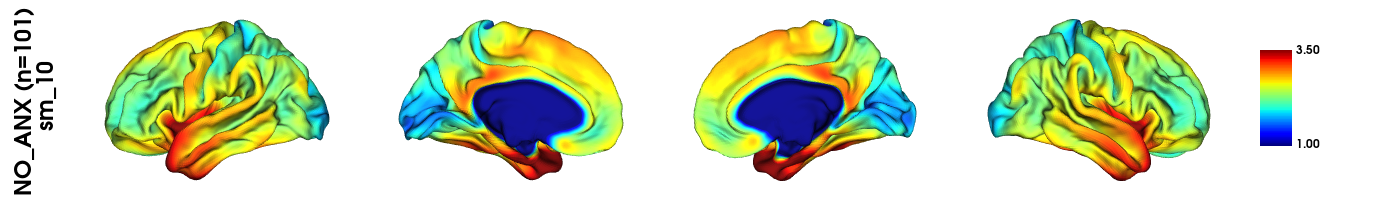

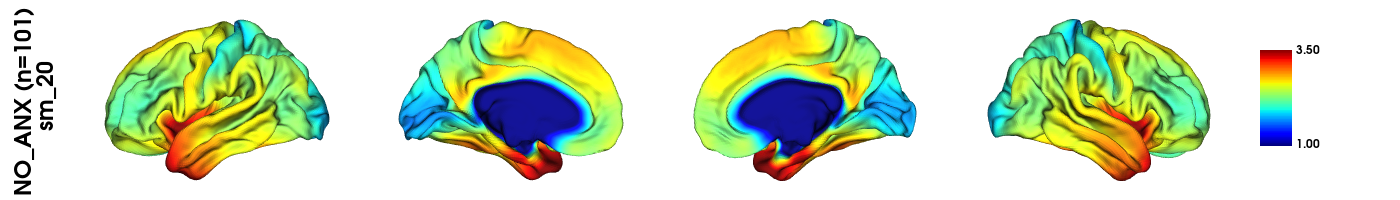

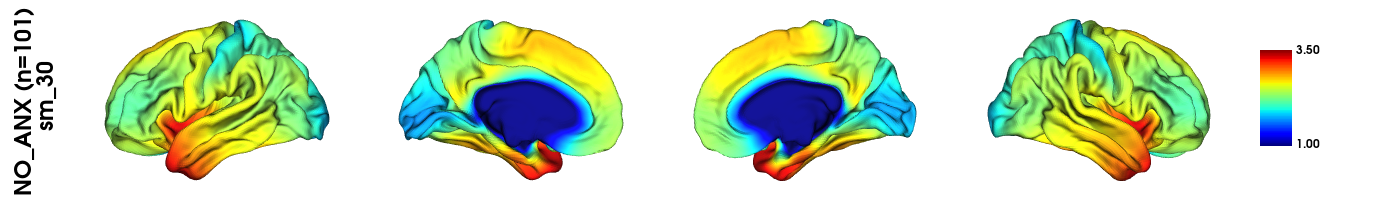

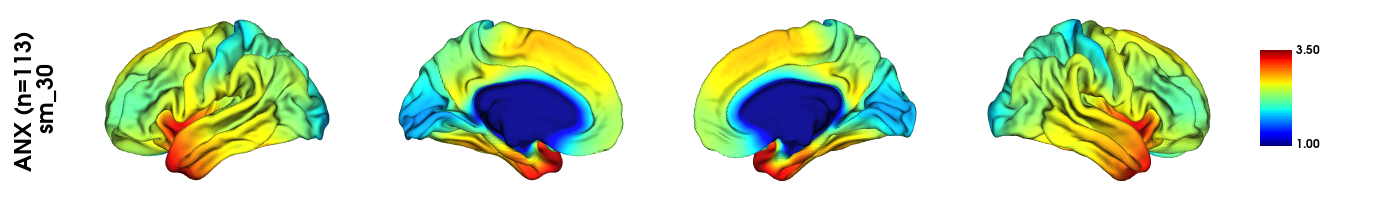

In [133]:
for smoothing_fwhm in range(10, 31, 10):
    tmp=np.array(valCT_NO_ANX[f"sm_{smoothing_fwhm}"])
    mean_CT=np.mean(tmp,axis=0)
    nb=f"{len(tmp)}"
    figure_title=os.path.join(STUDY_PATH,"screenshots",f"CT_NO_ANX_{nb}.png")
    plot_hemispheres(pial_left_fslr32k,pial_right_fslr32k,mean_CT, color_bar=True,                     
        label_text=[f"NO_ANX (n={nb}) \n sm_{smoothing_fwhm}"],cmap="jet", embed_nb=True, size=(1400, 200),color_range=(1,3.5), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))
    
    tmp=np.array(valCT_ANX[f"sm_{smoothing_fwhm}"])
    mean_CT=np.mean(tmp,axis=0)
    nb=f"{len(tmp)}"
    figure_title=os.path.join(STUDY_PATH,"screenshots",f"CT_ANX_{nb}.png")
    plot_hemispheres(pial_left_fslr32k,pial_right_fslr32k,mean_CT, color_bar=True,
        label_text=[f"ANX (n={nb}) \n sm_{smoothing_fwhm} "], cmap="jet", embed_nb=True, size=(1400, 200),color_range=(1,3.5), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))

## Affichage des cartes d'épaisseurs corticales après Z-Scores (individuel) pour chaque groupe avec lissage à 10, 20 et 30 mm

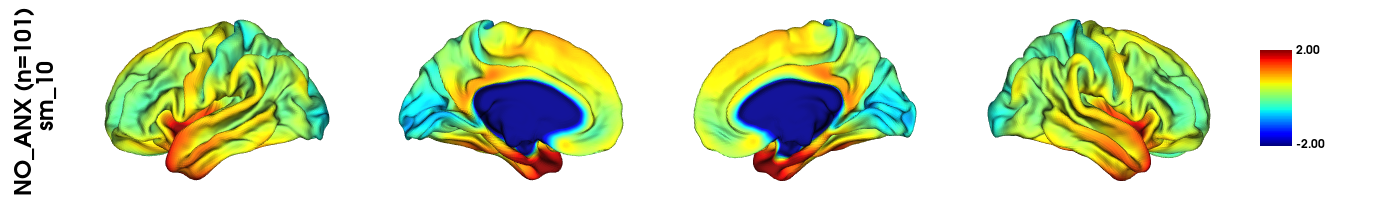

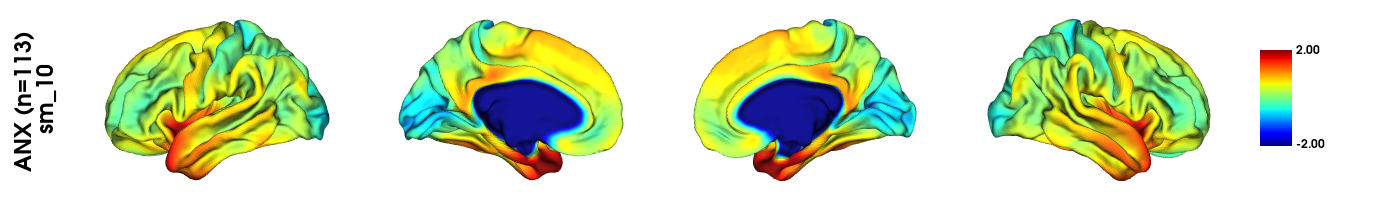

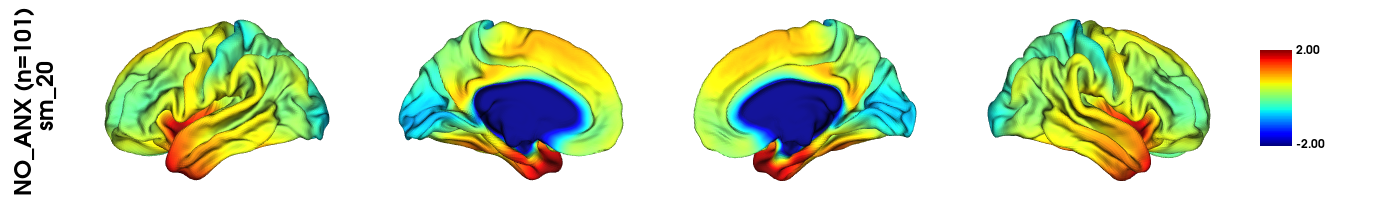

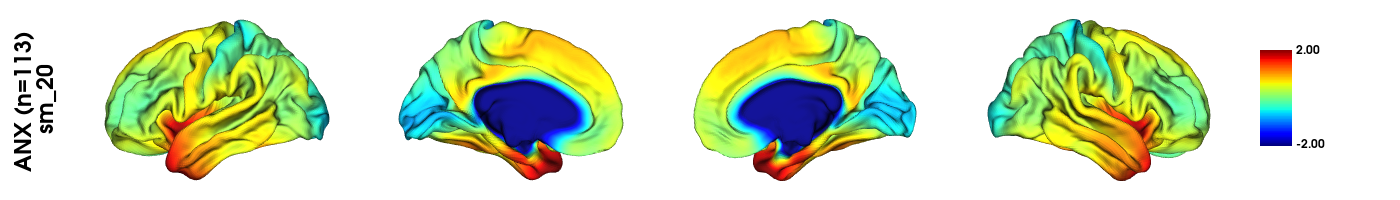

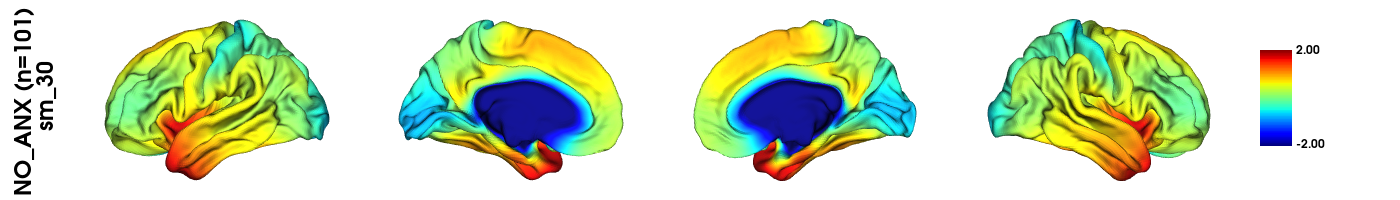

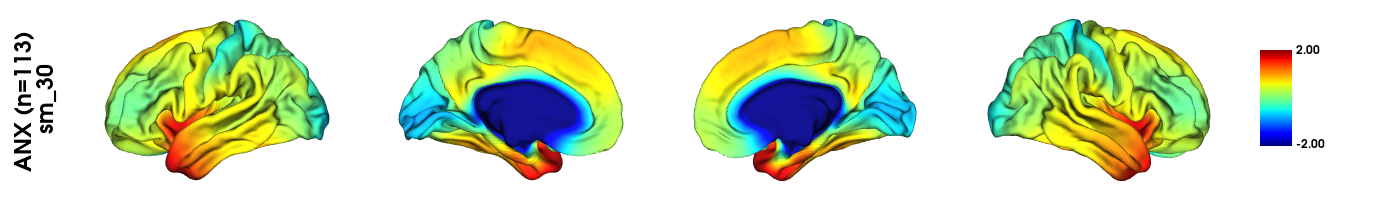

In [132]:
for smoothing_fwhm in range(10, 31, 10):
    tmp=np.array(valCT_NO_ANX[f"sm_{smoothing_fwhm}"])
    mean_CT=np.mean(stats.zscore(tmp,axis=1),axis=0)
    nb=f"{len(tmp)}"
    figure_title=os.path.join(STUDY_PATH,"screenshots",f"CT_NO_ANX_{nb}.png")
    plot_hemispheres(pial_left_fslr32k,pial_right_fslr32k,mean_CT, color_bar=True,                     
        label_text=[f"NO_ANX (n={nb}) \n sm_{smoothing_fwhm}"],cmap="jet", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12},color_range=(-2,2),
        interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))
    
    tmp=np.array(valCT_ANX[f"sm_{smoothing_fwhm}"])
    mean_CT=np.mean(stats.zscore(tmp,axis=1),axis=0)
    nb=f"{len(tmp)}"
    nb=f"{len(tmp)}"
    figure_title=os.path.join(STUDY_PATH,"screenshots",f"CT_ANX_{nb}.png")
    plot_hemispheres(pial_left_fslr32k,pial_right_fslr32k,mean_CT, color_bar=True,
        label_text=[f"ANX (n={nb}) \n sm_{smoothing_fwhm} "], cmap="jet", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12},color_range=(-2,2), 
        interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))

# Statistiques

## fslr32k : modèle linéaire généralisé (GLM)

In [455]:
term_sexe = FixedEffect(merged_data.Sexe)
model_sexe = term_sexe

#dans l'ordre initiale
term_group = FixedEffect(merged_data.GROUP_NAME)
model_group = term_group

#dans l'ordre ANX d'abord puis NO_ANX ensuite (pour faire comme dans la matrice qui l'on donne en entrée)
vecteur_ANX = merged_data['ANX'][merged_data['ANX'] == 1].values
vecteur_NO_ANX = merged_data['ANX'][merged_data['ANX'] == 0].values
df_GRP=["ANX" if x == 1 else "NO_ANX" for x in np.concatenate([vecteur_NO_ANX, vecteur_ANX])]

term_group = FixedEffect(df_GRP,"GRP")
model_group_sscov = term_group

#model_pasbdi= term_pas + term_bdi

#define dans l'ordre de merge dat 
#conrtrase 1(ANX),-1(NO_ANX)
contrast_group = (merged_data.GROUP_NAME == "ANX").astype(int) - (merged_data.GROUP_NAME == "NO_ANX").astype(int)
#ou contrast_group = (merged_data['ANX']== 1).astype(int) - (merged_data['ANX']== 0).astype(int)

#define dans l'ordre de merge dat 
#contraste 1(NO_ANX),-1(ANX)
#contrast_group=np.concatenate([vecteur_NO_ANX+1, vecteur_ANX-2])

In [456]:
reswocov_FIT = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in range(10, 31, 10)}
reswcov_FIT = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in range(10, 31, 10)}

for smoothing_fwhm in range(10, 31, 10):
    tmp_NO_ANX = np.array(valCT_NO_ANX[f"sm_{smoothing_fwhm}"])
    tmp_ANX = np.array(valCT_ANX[f"sm_{smoothing_fwhm}"])  
    val_CT = np.concatenate([tmp_NO_ANX, tmp_ANX], axis=0)
    
    # Ajouter la colonne SUBJ_ID en utilisant les index
    merged_data_SUBJcol = merged_data.reset_index().rename(columns={'index': 'SUBJ'})
    
    # Définir les termes du modèle pour les groupes ANX et NO_ANX
    term_group = FixedEffect(merged_data_SUBJcol["GROUP_NAME"])
    term_age = FixedEffect(merged_data_SUBJcol["Age"])
    term_sex = FixedEffect(merged_data_SUBJcol["Sexe"])
    term_subject = MixedEffect(merged_data_SUBJcol["SUBJ"])
    
    # Créer le modèle sans covariables
    model_group = term_group + term_subject
    model_group_age_sex = term_group
    
    # Créer le modèle avec covariables
    #model_group_age_sex = term_group + term_age + term_sex + term_age * term_sex + term_subject
    for varc in ["Age","Sexe"]:
        model_group_age_sex = model_group_age_sex + FixedEffect(merged_data_SUBJcol[varc])
    
    # Ajuster le modèle sans covariables
    slm_group_sscov = SLM(
        model_group,
        contrast_group,
        surf=pial_combined_fslr32k,
        mask=mask_fslr32k,
        correction=["fdr", "rft"],
        two_tailed=True,
        cluster_threshold=0.05,
    )
    slm_group_sscov.fit(val_CT)
    reswocov_FIT[f"sm_{smoothing_fwhm}"] = slm_group_sscov
    
    # Ajuster le modèle avec covariables
    slm_group_wcov = SLM(
        model_group_age_sex,
        contrast_group,
        surf=pial_combined_fslr32k,
        mask=mask_fslr32k,
        correction=["fdr", "rft"],
        two_tailed=True,
        cluster_threshold=0.05,
    )
    slm_group_wcov.fit(val_CT)
    reswcov_FIT[f"sm_{smoothing_fwhm}"] = slm_group_wcov

### Contraste de groupe sans prise en compte de covariables

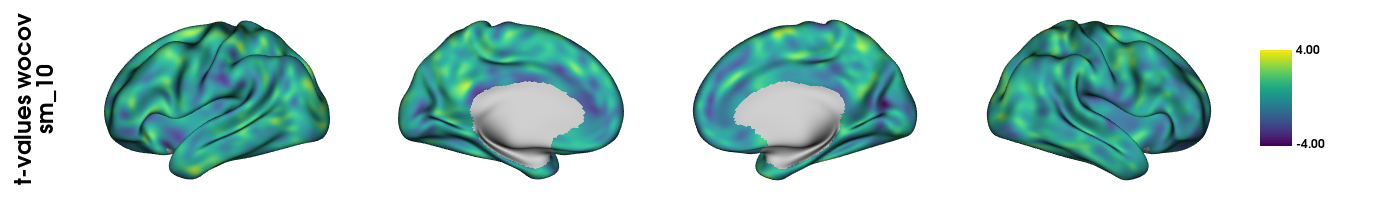

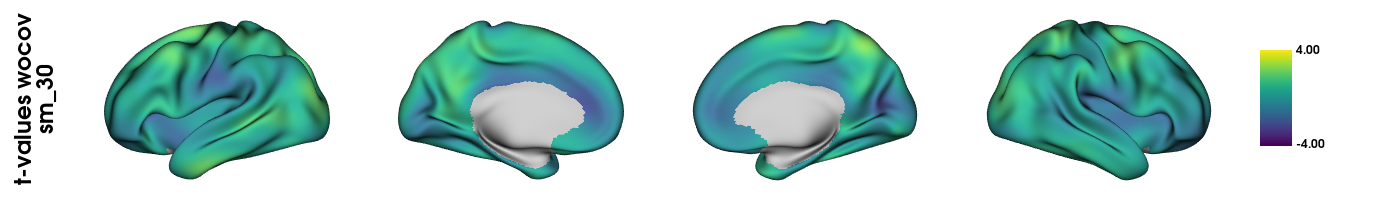

In [458]:
for smoothing_fwhm in range(10, 31, 10):
    figure_title=os.path.join(STUDY_PATH,"screenshots",f"t_stat_wocov_sm_{smoothing_fwhm}.png")
    plot_hemispheres(inflated_left_fslr32k,inflated_right_fslr32k,reswocov_FIT[f'sm_{smoothing_fwhm}'].t, color_bar=True, color_range=(-4, 4),
            label_text=[f"t-values wocov\nsm_{smoothing_fwhm}"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
            nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=True,
            screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))

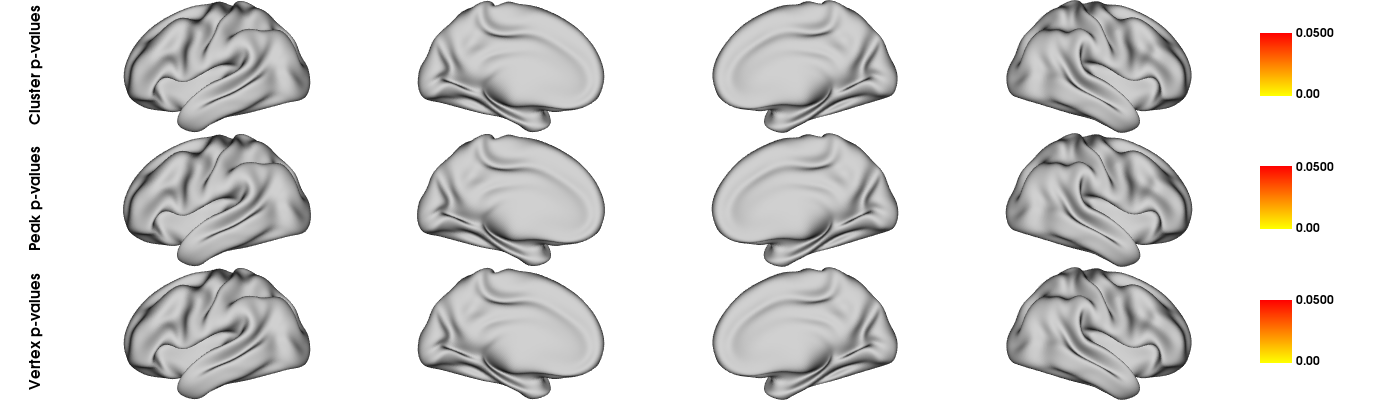

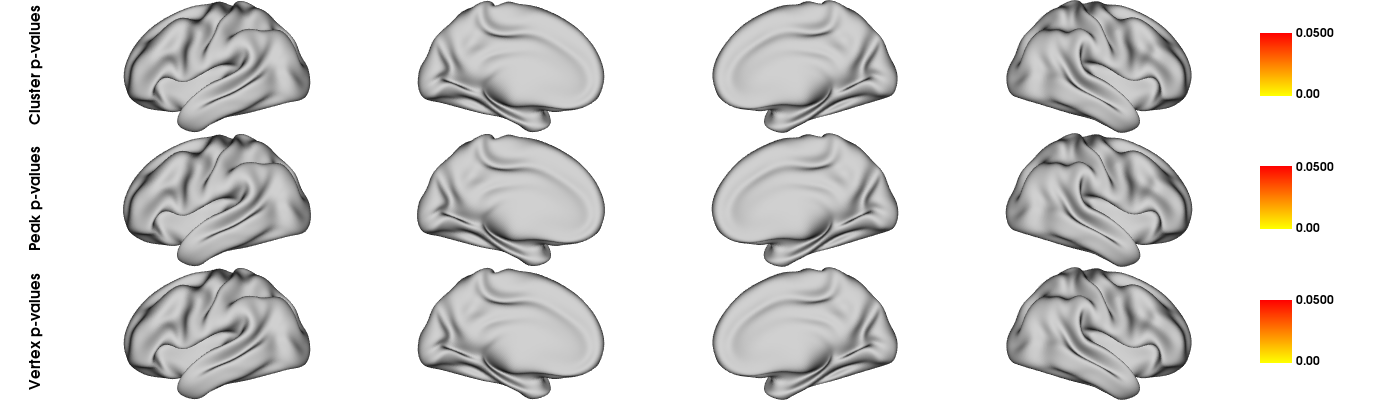

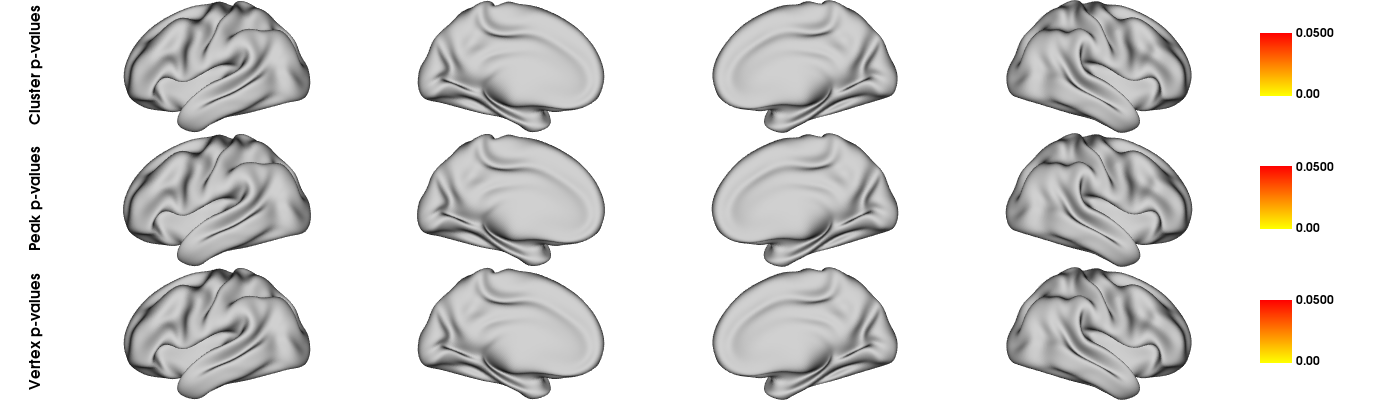

In [461]:
for smoothing_fwhm in range(10, 31, 10):
    figure_title=os.path.join(STUDY_PATH,"screenshots",f"others_stat_sm_{smoothing_fwhm}.png")
    slm_group=reswocov_FIT[f'sm_{smoothing_fwhm}']
    cp = [np.copy(slm_group.P["pval"]["C"])]
    [np.place(x, np.logical_or(x > 0.05, ~mask_fslr32k), np.nan) for x in cp]

    pp = [np.copy(slm_group.P["pval"]["P"])]
    [np.place(x, np.logical_or(x > 0.05, ~mask_fslr32k), np.nan) for x in pp]

    qp = [np.copy(slm_group.Q)]
    [np.place(x, np.logical_or(x > 0.05, ~mask_fslr32k), np.nan) for x in qp]

    vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])
    plot_hemispheres(inflated_left_fslr32k,inflated_right_fslr32k,vals, color_bar=True, color_range=(0, 0.05),
                     label_text=["Cluster p-values", "Peak p-values", "Vertex p-values"], cmap="autumn_r", 
                     embed_nb=True, size=(1400, 400), zoom=1.8, nan_color=(0.7, 0.7, 0.7, 1), 
                     cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=True,screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))

### Contraste de groupe avec prise en compte de covariables

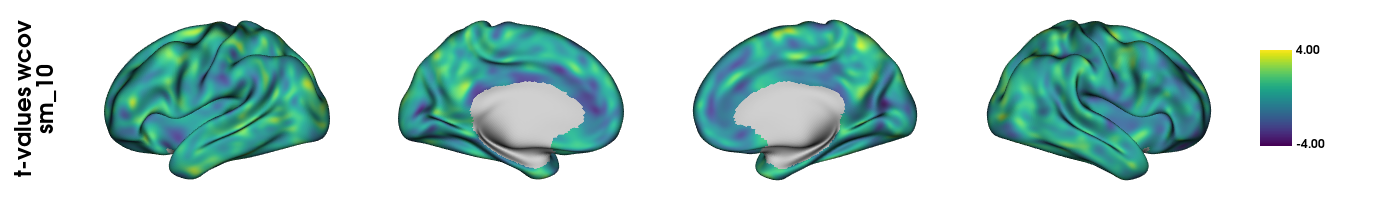

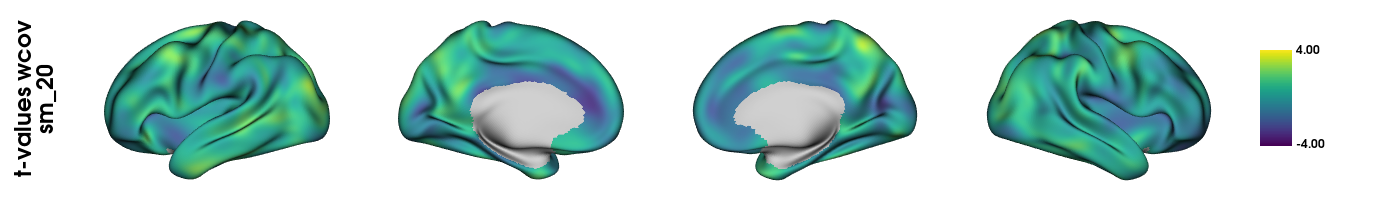

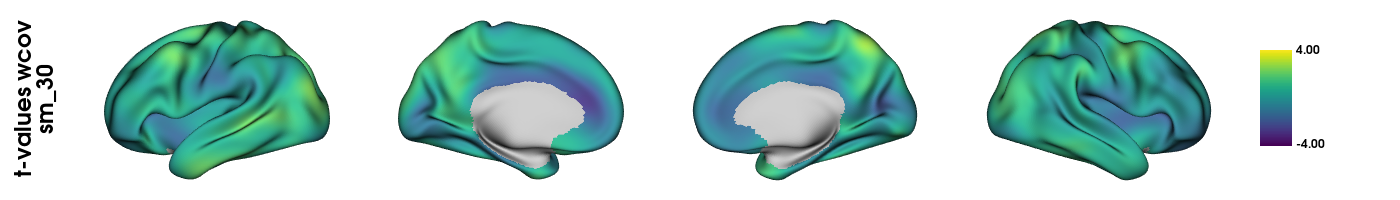

In [460]:
for smoothing_fwhm in range(10, 31, 10):
    figure_title=os.path.join(STUDY_PATH,"screenshots",f"t_stat_wcov_sm_{smoothing_fwhm}.png")
    plot_hemispheres(inflated_left_fslr32k,inflated_right_fslr32k,reswcov_FIT[f'sm_{smoothing_fwhm}'].t, color_bar=True, color_range=(-4, 4),
            label_text=[f"t-values wcov\nsm_{smoothing_fwhm}"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
            nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=True,
            screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))

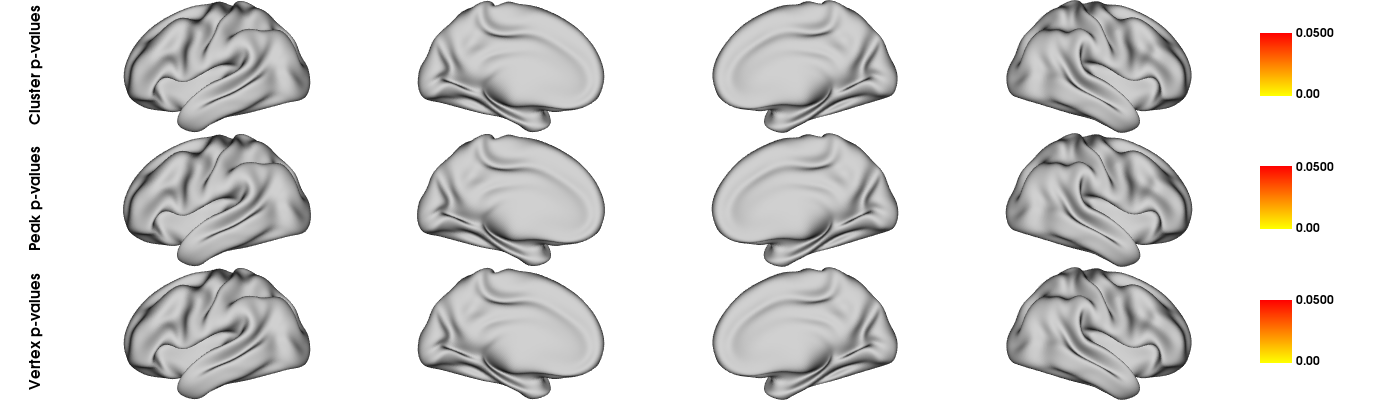

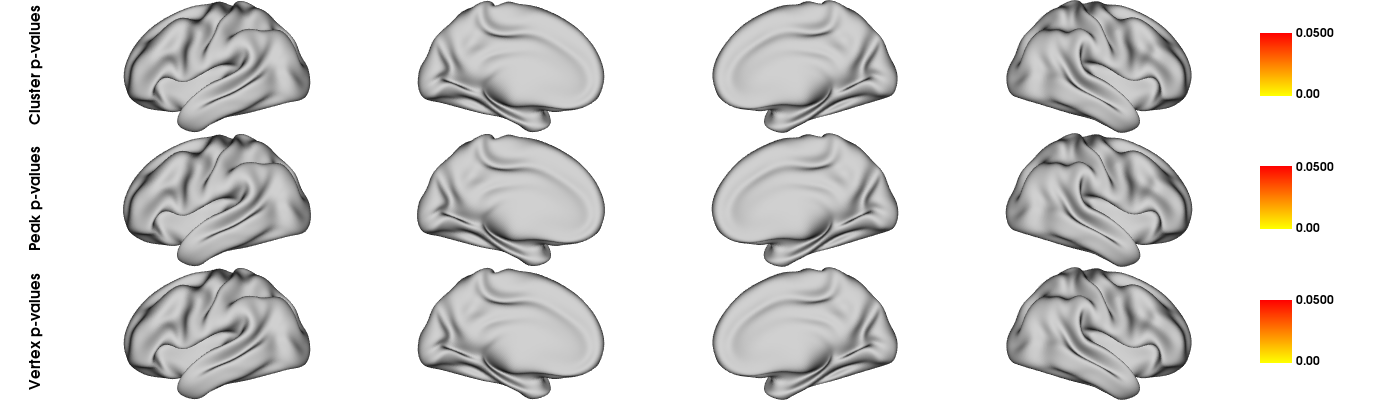

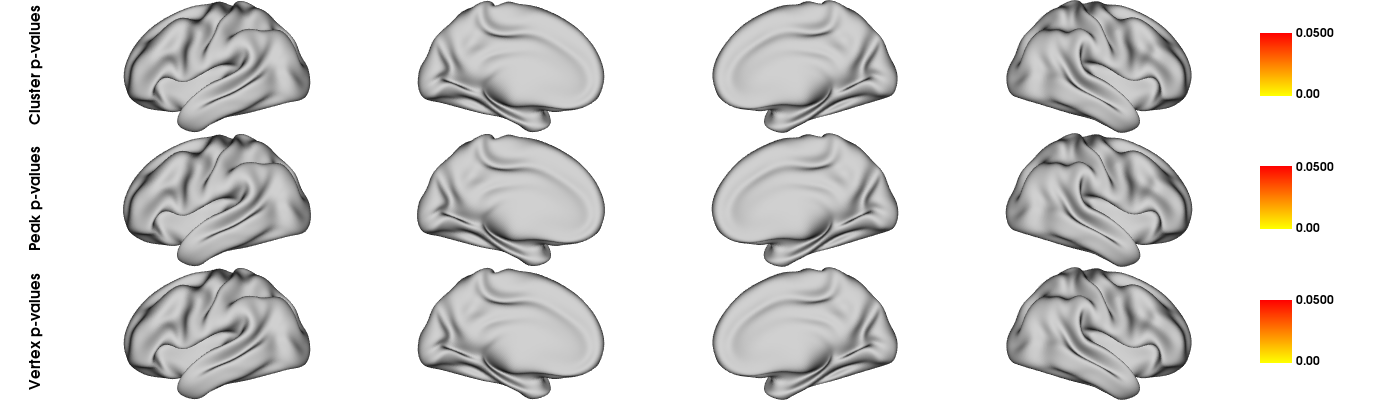

In [ ]:
for smoothing_fwhm in range(10, 31, 10):
    figure_title=os.path.join(STUDY_PATH,"screenshots",f"others_stat_sm_{smoothing_fwhm}.png")
    slm_group=reswcov_FIT[f'sm_{smoothing_fwhm}']
    cp = [np.copy(slm_group.P["pval"]["C"])]
    [np.place(x, np.logical_or(x > 0.05, ~mask_fslr32k), np.nan) for x in cp]

    pp = [np.copy(slm_group.P["pval"]["P"])]
    [np.place(x, np.logical_or(x > 0.05, ~mask_fslr32k), np.nan) for x in pp]

    qp = [np.copy(slm_group.Q)]
    [np.place(x, np.logical_or(x > 0.05, ~mask_fslr32k), np.nan) for x in qp]

    vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])
    plot_hemispheres(inflated_left_fslr32k,inflated_right_fslr32k,vals, color_bar=True, color_range=(0, 0.05),
                     label_text=["Cluster p-values", "Peak p-values", "Vertex p-values"], cmap="autumn_r", 
                     embed_nb=True, size=(1400, 400), zoom=1.8, nan_color=(0.7, 0.7, 0.7, 1), 
                     cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=True,screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))

## Atlas Glasser


 smoothing_fwhm=10
a24_R : p_fdr=0.8235 p_value=0.0072
TE2a_R : p_fdr=0.3655 p_value=0.002
TE2p_R : p_fdr=0.0735 p_value=0.0002


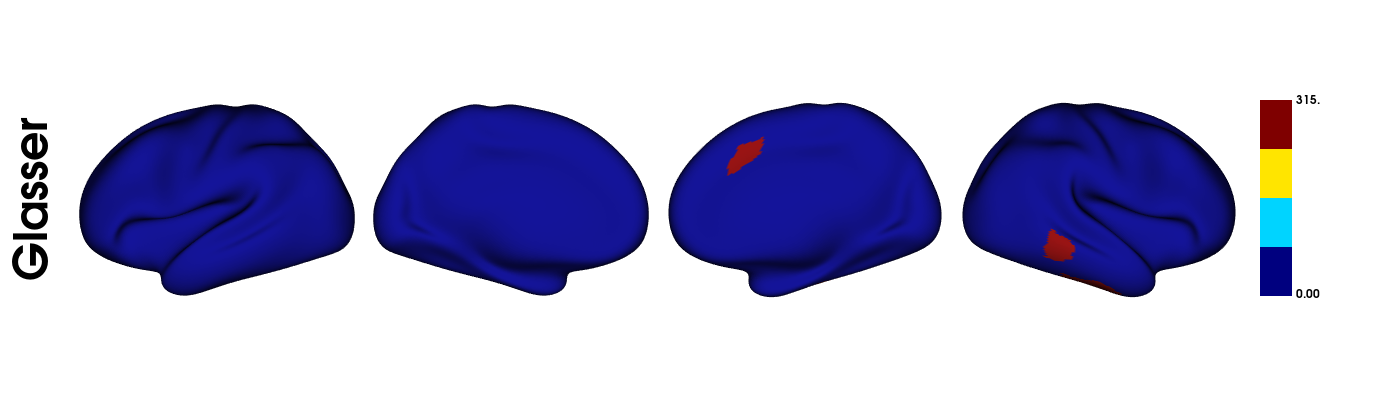


 smoothing_fwhm=20
TE2a_R : p_fdr=0.2403 p_value=0.0013
TE2p_R : p_fdr=0.0618 p_value=0.0002


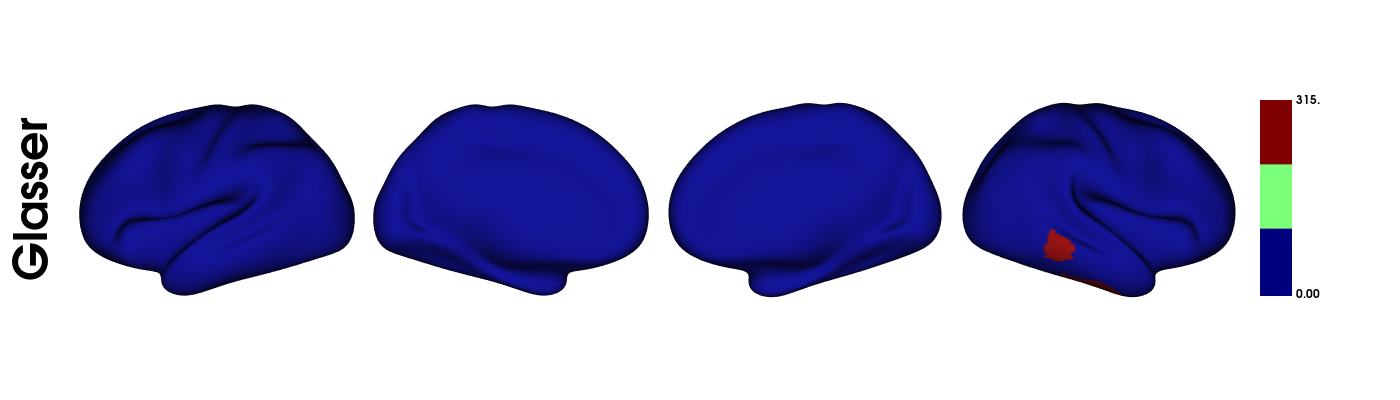


 smoothing_fwhm=30
52_L : p_fdr=0.2306 p_value=0.0026
MBelt_L : p_fdr=0.322 p_value=0.0045
FFC_R : p_fdr=0.4701 p_value=0.0078
TE2a_R : p_fdr=0.2306 p_value=0.0021
TF_R : p_fdr=0.2306 p_value=0.0014
TE2p_R : p_fdr=0.0799 p_value=0.0002


/tmp/ipykernel_3011259/1644886475.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


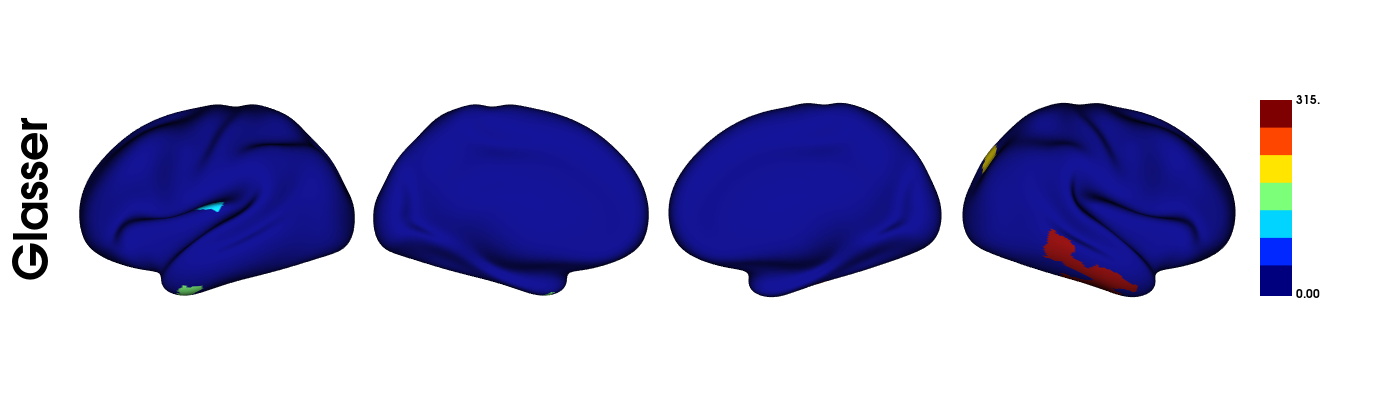

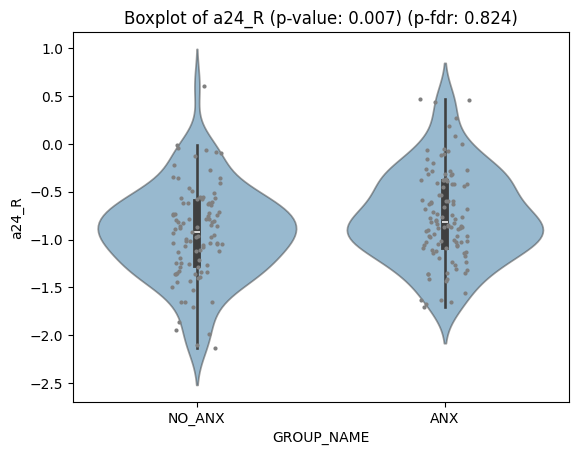

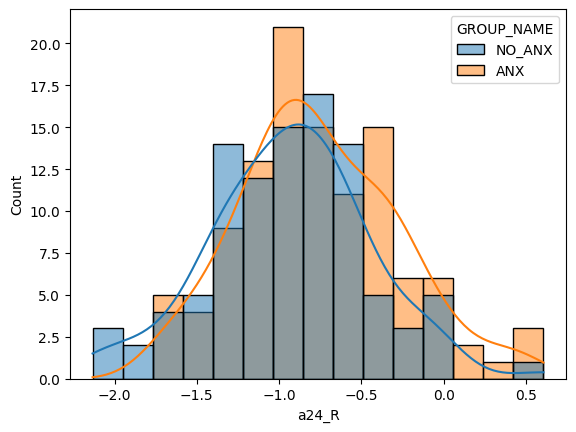

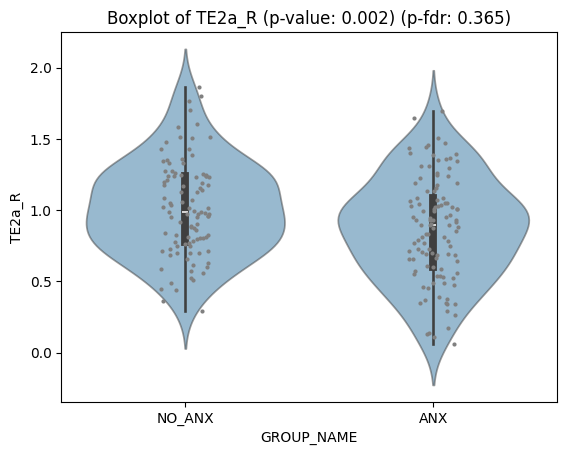

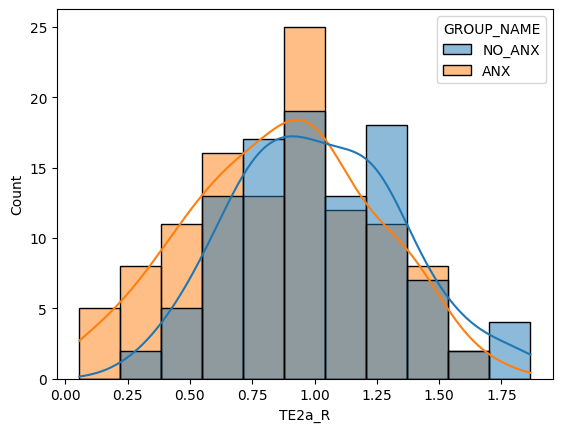

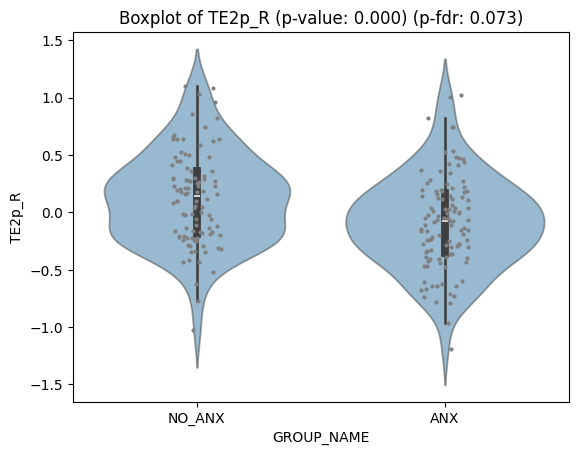

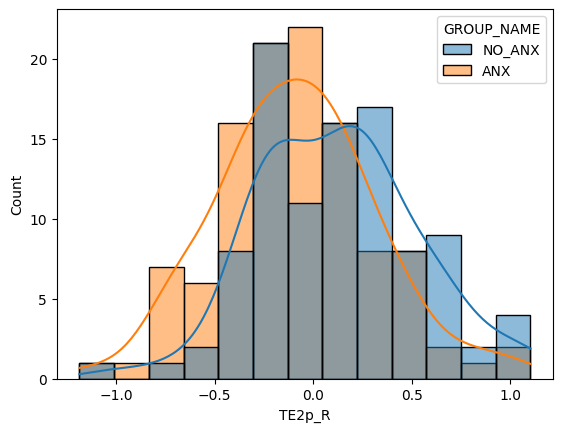

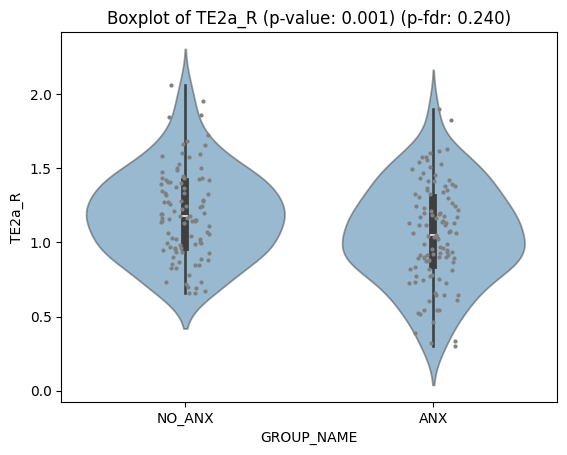

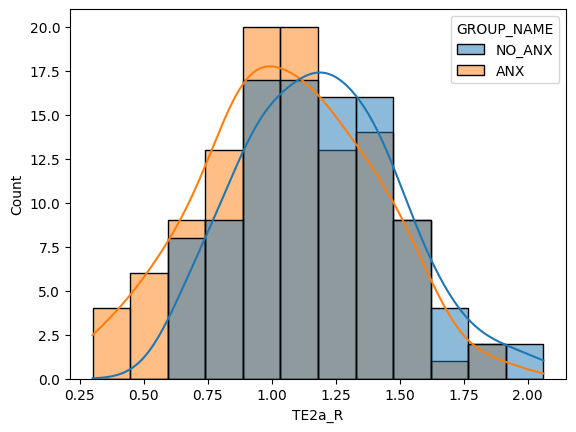

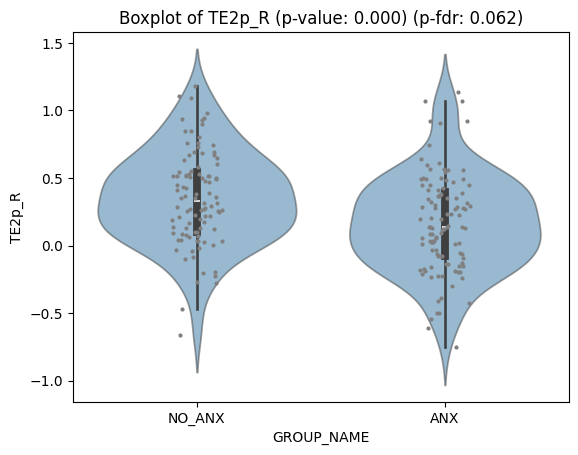

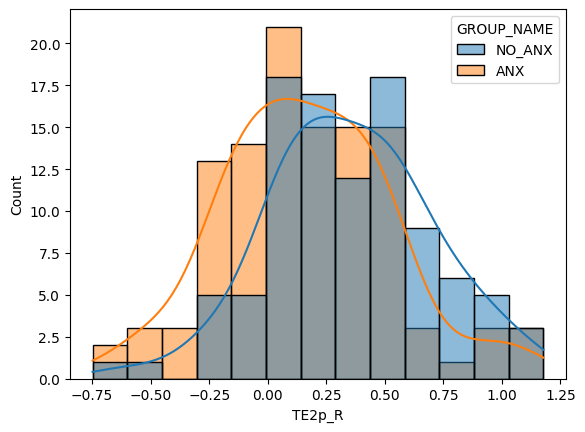

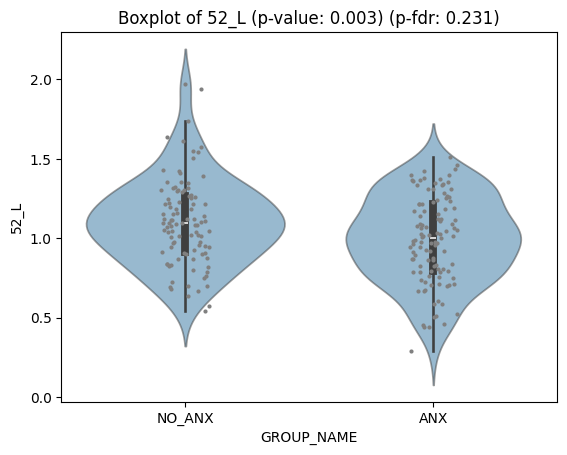

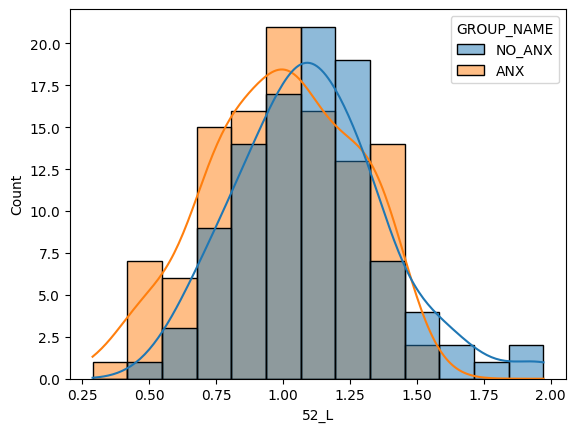

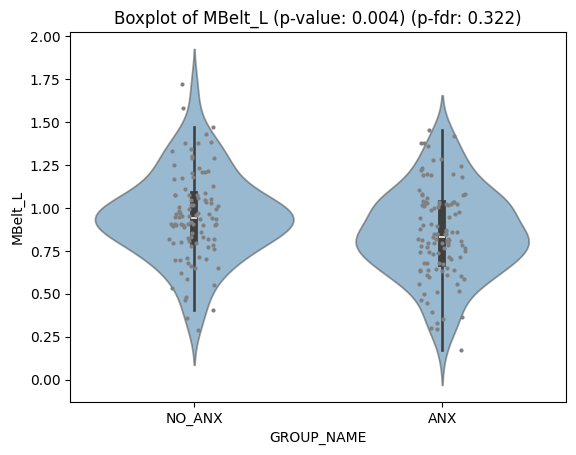

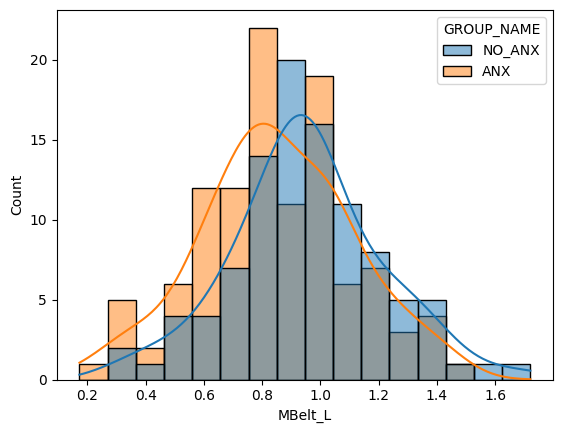

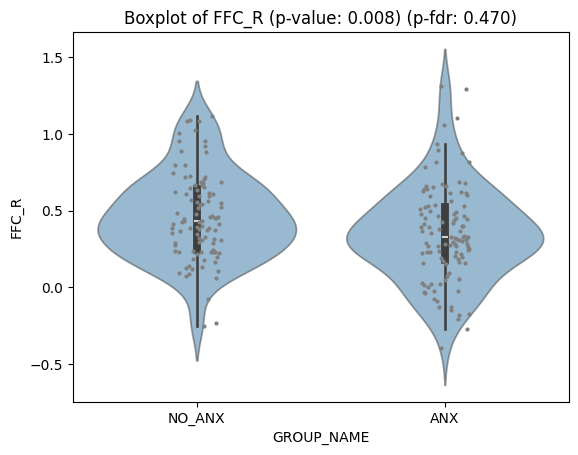

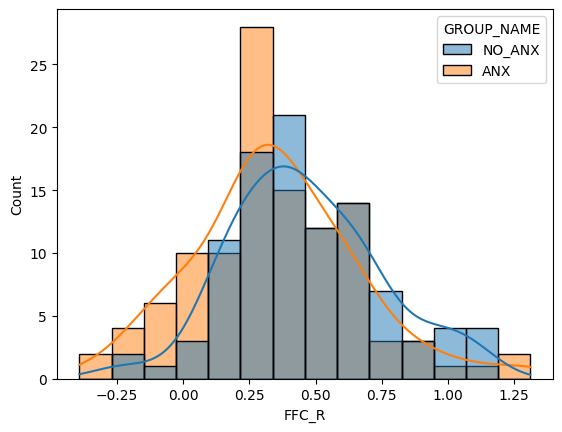

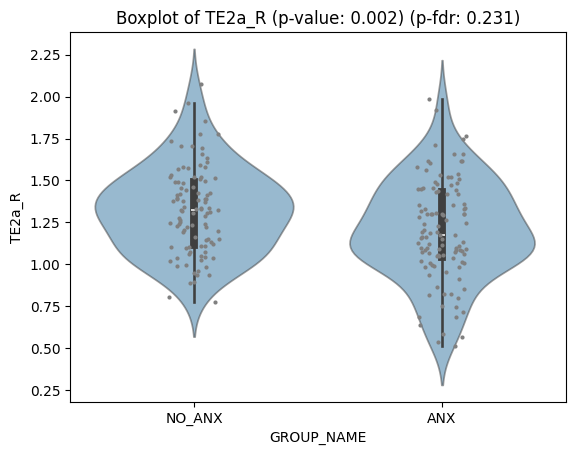

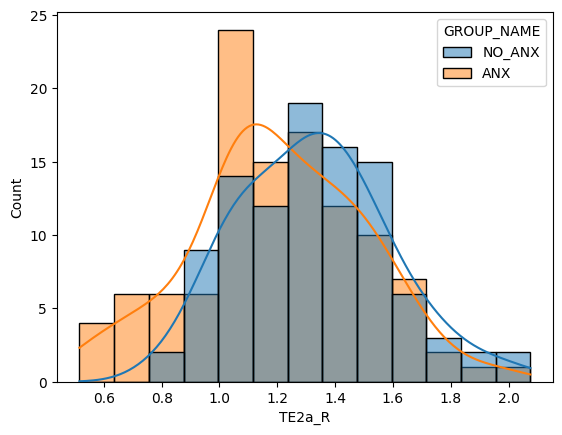

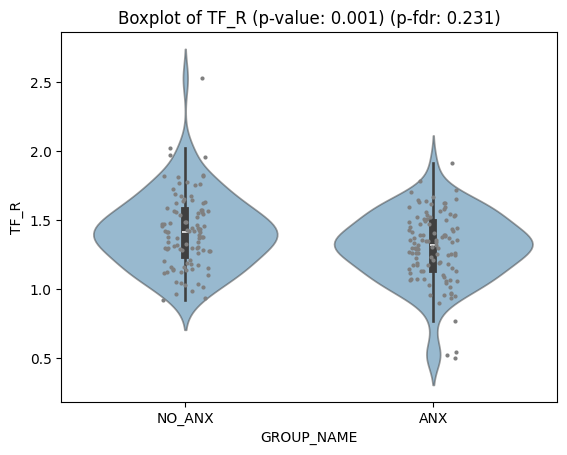

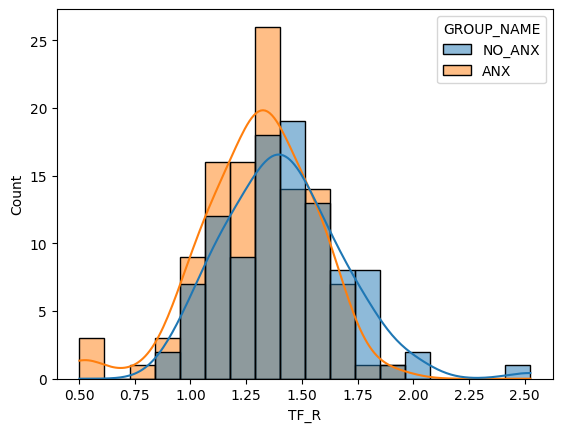

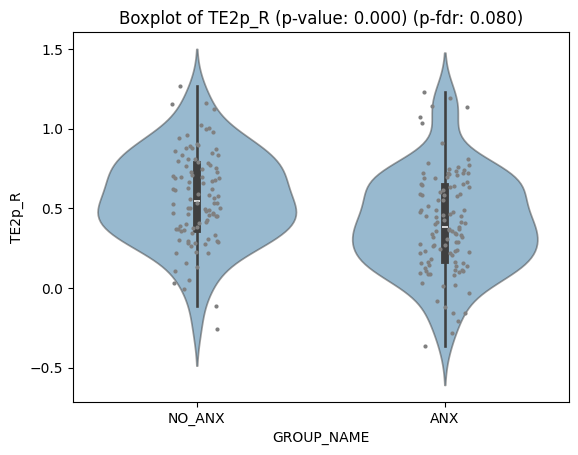

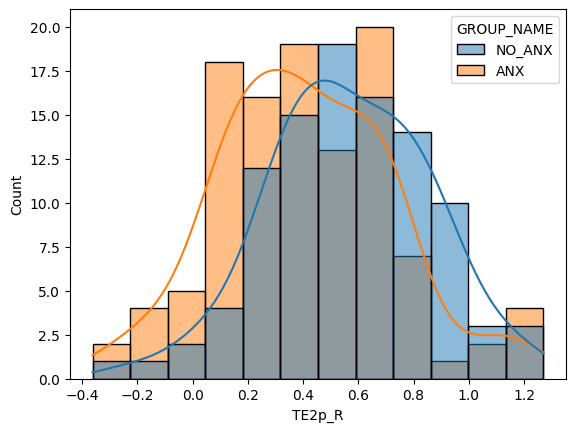

In [462]:
#il manque trois niveau d'education (n=214 à n=211)
covarQuant = ["Age","NB_YEAR_SCHO"]
covarQual=["Sexe","CentreAqui"]

for smoothing_fwhm in range(10, 31, 10):
    print(f"\n smoothing_fwhm={smoothing_fwhm}")

    df_res = pd.DataFrame(np.round(np.array(res[f"sm_{smoothing_fwhm}"]),3), columns=["EXT"]+list(df_exthcp["regionName"].values), index=merged_data.index)
    df_res = df_res.drop(columns=['EXT'])
    df_res = df_res.rename_axis("SUBJ")

    columns_of_interest=list(df_res.columns)
    #columns_of_interest = [col for col in df_res.columns if "FOP4" in col or "AAIC" in col or "PI" in col]
    #columns_of_interest = [col for col in df_res.columns if "23c" in col or "PHT" in col or "TPOJ" in col]  

    p_values=[]
    roiOnGlasser=(glasser_fslr32k==9999999)*0
    merged_data_with_res=merged_data.join(df_res)
    # Remplacer les valeurs infinies par NaN dans le DataFrame merged_data_with_res
    #merged_data_with_res = merged_data_with_res[columns_of_interest+["GROUP_NAME"]].replace([np.inf, -np.inf], np.nan)
    merged_data_with_res=merged_data_with_res[['GROUP_NAME']+covarQuant+covarQual+columns_of_interest].dropna()

    #Régression de l'age et du niveau d'education
    lbr.regress_covar_func(columns_of_interest,covarQuant,merged_data_with_res,merged_data_with_res,False)

    # Fonction pour appliquer le Z-score sur les colonnes d'intérêt
    def apply_zscore(group):
        group[columns_of_interest] = group[columns_of_interest].apply(stats.zscore, axis=1)
        return group

    #Suppression de l'effet centre et sexe en faisant un zscore par combinaison
    # Appliquer le Z-score pour chaque combinaison de Sexe et CentreAqui
    merged_data_with_res_zscore = merged_data_with_res.groupby(['Sexe', 'CentreAqui']).apply(apply_zscore)

    # Effectuer un test t de Student et afficher les boxplots si significatif
    for col in columns_of_interest:
        group1 = merged_data_with_res_zscore[merged_data_with_res_zscore['GROUP_NAME'] == 'ANX'][col]
        group2 = merged_data_with_res_zscore[merged_data_with_res_zscore['GROUP_NAME'] == 'NO_ANX'][col]
        #print(f"Effectuer le test t de Student pour la colonne {col}")
        #print(f"Taille du groupe ANX : {group1.shape[0]}")
        #print(f"Taille du groupe NO_ANX : {group2.shape[0]}")
        # Effectuer le test t de Student
        t_stat, p_value = ttest_ind(group1.dropna(), group2.dropna())
        p_values.append(p_value)
        
    b_fdr,p_fdr=sm.stats.fdrcorrection(p_values,alpha=0.05,method='indep',is_sorted=False)
    for elt in zip(p_fdr,columns_of_interest,p_values):    
        if elt[2]<0.01 :
            print(f"")
            plt.figure()
            sns.stripplot(data=merged_data_with_res_zscore,y=elt[1],x="GROUP_NAME",size=3,color="gray")
            sns.violinplot(data=merged_data_with_res_zscore,y=elt[1],x="GROUP_NAME",alpha=0.5)
            plt.title(f'Boxplot of {elt[1]} (p-value: {elt[2]:.3f}) (p-fdr: {elt[0]:.3f})')
            p=plt.figure()
            sns.histplot(data=merged_data_with_res_zscore, x=elt[1],kde=True,hue="GROUP_NAME",bins='auto')
            filtered_df = df_exthcp[df_exthcp['regionName'] == elt[1]]
            roi_index=filtered_df['Cortex_ID'].index.values
            roiOnGlasser=roiOnGlasser+((glasser_fslr32k==roi_index)*roi_index)
            print(f'{lbr.ansi_colors[clu]} {lbr.BOLD} {elt[1]} : p_fdr={round(elt[0],4)} p_value={round(elt[2],4)} {lbr.RESET}')

    figure_title=os.path.join(STUDY_PATH,"screenshots",f"Glasser_{smoothing_fwhm}.png")
    plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,roiOnGlasser, color_bar=True,
            label_text=["Glasser"], cmap="jet", 
            embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
            cb__labelTextProperty={"fontSize": 12},transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))

## Atlas extended HCP


 smoothing_fwhm=10
Posterior_Cingulate_L  :  0.6886 0.4632
Paracentral_Lobular_and_Mid_Cingulate_L  :  0.6886 0.6886
Anterior_Cingulate_and_Medial_Prefrontal_L  :  0.3634 0.0606
Posterior_Cingulate_R  :  0.6886 0.6698
Paracentral_Lobular_and_Mid_Cingulate_R  :  0.4836 0.1612
Anterior_Cingulate_and_Medial_Prefrontal_R  :  0.6886 0.669


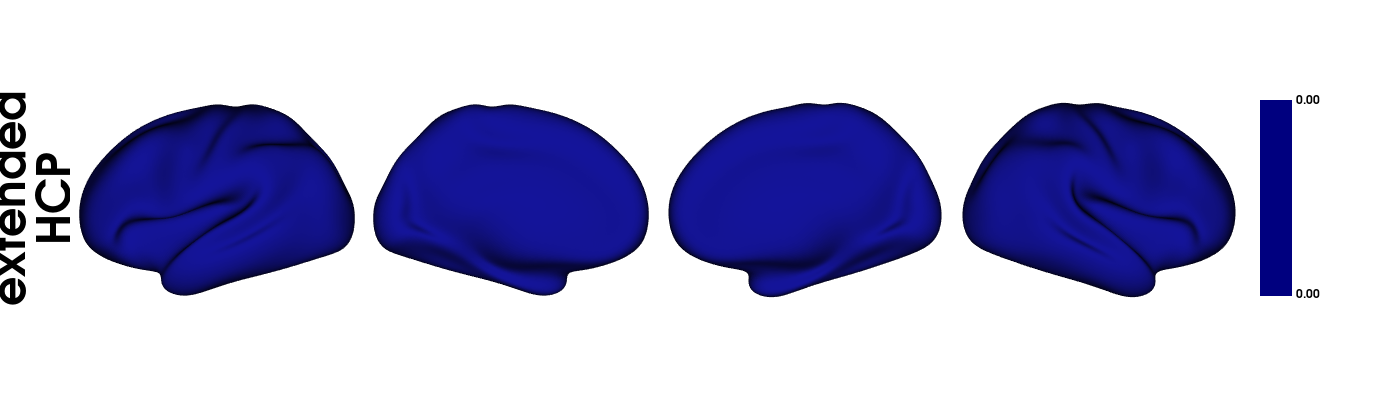


 smoothing_fwhm=20
Posterior_Cingulate_L  :  0.5924 0.4202
Paracentral_Lobular_and_Mid_Cingulate_L  :  0.5924 0.5924
Anterior_Cingulate_and_Medial_Prefrontal_L  :  0.2697 0.045
(0.2697462908547244, 'Anterior_Cingulate_and_Medial_Prefrontal_L', 0.044957715142454065)
Anterior_Cingulate_and_Medial_Prefrontal_L  :  0.2697
Posterior_Cingulate_R  :  0.5924 0.4153
Paracentral_Lobular_and_Mid_Cingulate_R  :  0.3448 0.1149
Anterior_Cingulate_and_Medial_Prefrontal_R  :  0.5924 0.5649


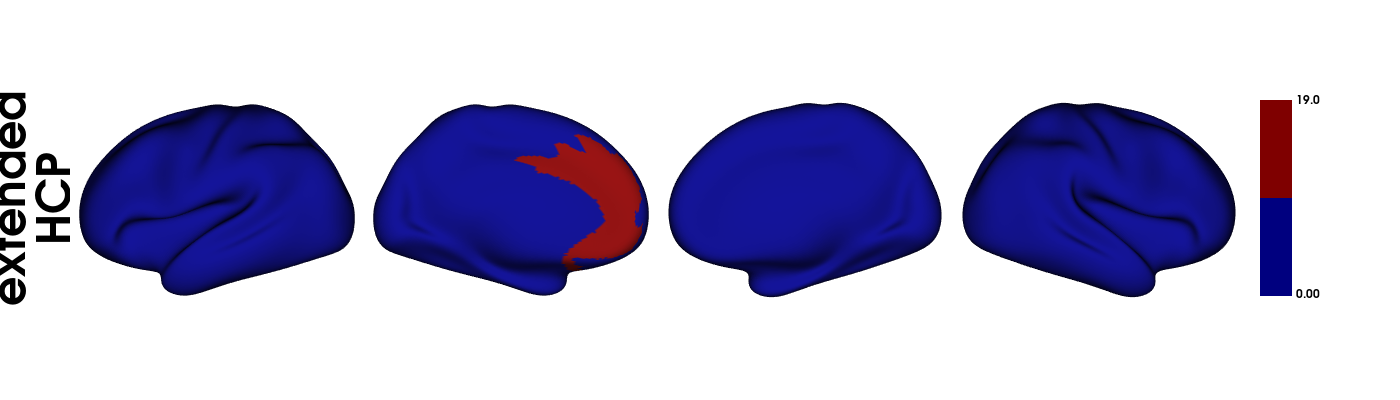


 smoothing_fwhm=30
Posterior_Cingulate_L  :  0.4793 0.3211
Paracentral_Lobular_and_Mid_Cingulate_L  :  0.512 0.512
Anterior_Cingulate_and_Medial_Prefrontal_L  :  0.2125 0.0372
(0.21253985366982917, 'Anterior_Cingulate_and_Medial_Prefrontal_L', 0.03717971846444026)
Anterior_Cingulate_and_Medial_Prefrontal_L  :  0.2125
Posterior_Cingulate_R  :  0.4793 0.2733
Paracentral_Lobular_and_Mid_Cingulate_R  :  0.2125 0.0708
Anterior_Cingulate_and_Medial_Prefrontal_R  :  0.4793 0.3994


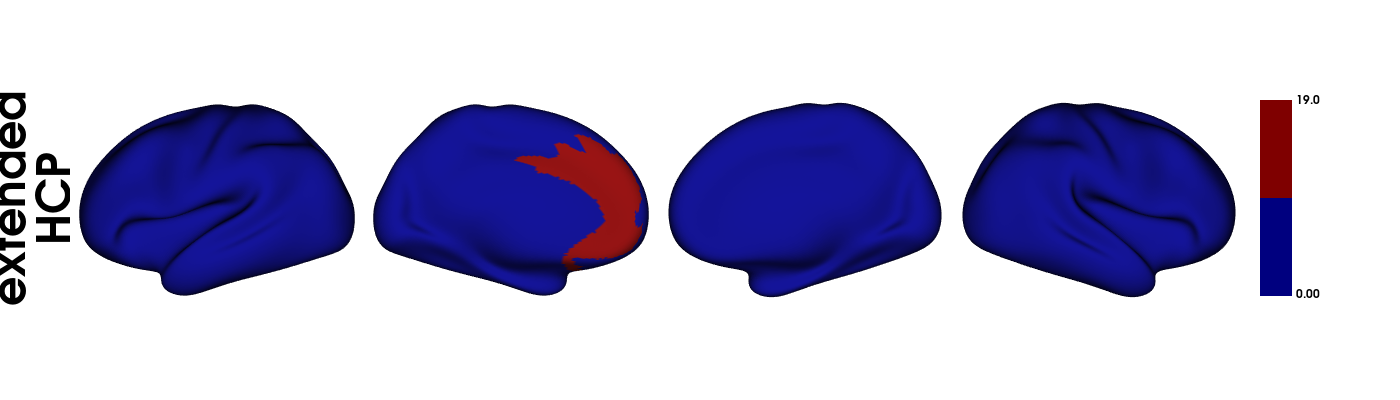

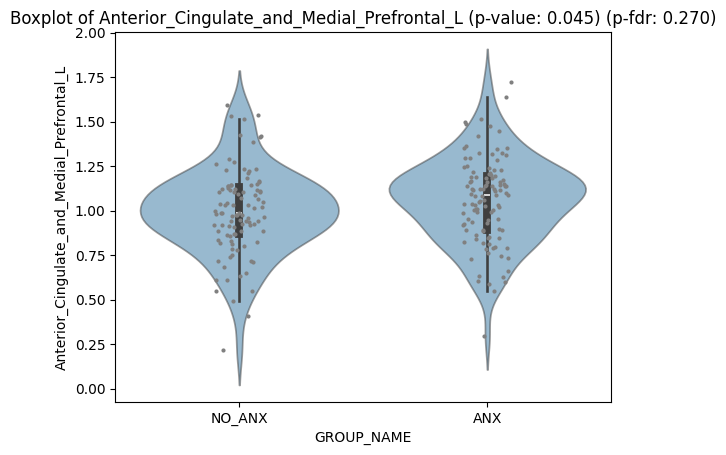

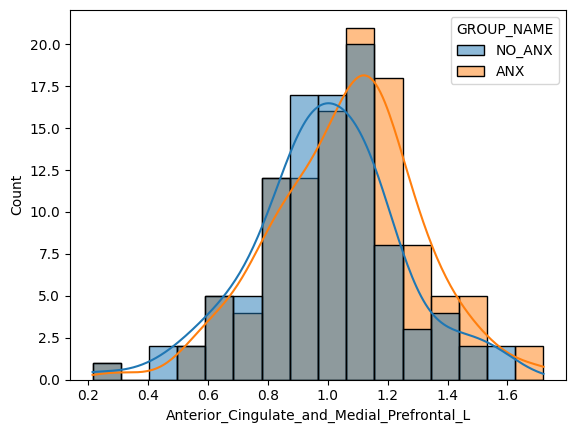

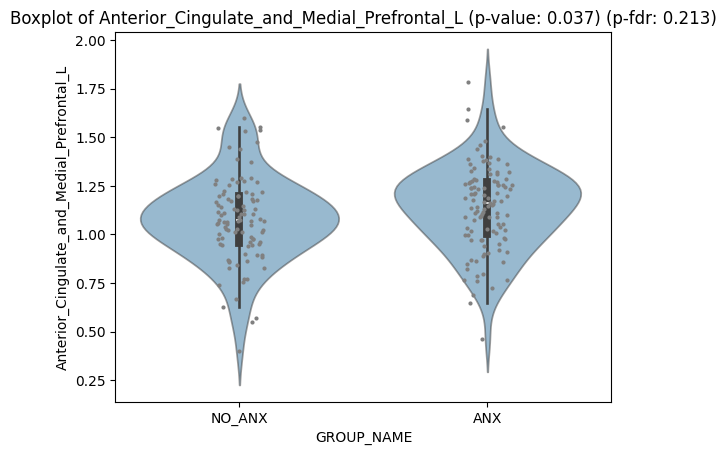

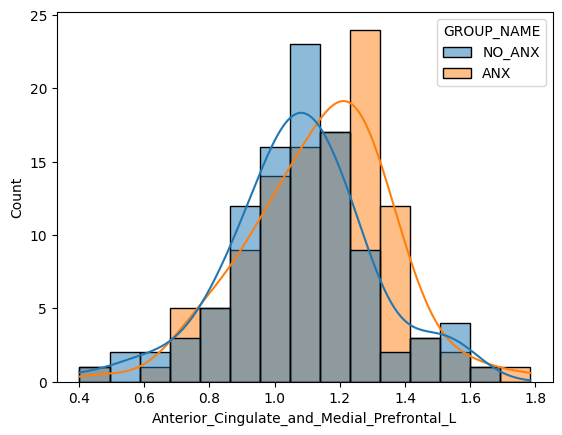

In [442]:
#il manque trois niveau d'education (n=214 à n=211)
covarQuant = ["Age","NB_YEAR_SCHO"]
covarQual=["Sexe","CentreAqui"]

for smoothing_fwhm in range(10, 31, 10):
    print(f"\n smoothing_fwhm={smoothing_fwhm}")
    df_res_exthcp = pd.DataFrame(np.round(np.array(res_exthcp[f"sm_{smoothing_fwhm}"]),3),columns=concatenated_list, index=merged_data.index)
    df_res_exthcp = df_res_exthcp.drop(columns=['EXT'])
    df_res_exthcp = df_res_exthcp.rename_axis("SUBJ")

    columns_of_interest=list(df_res_exthcp.columns)
    columns_of_interest = [col for col in df_res_exthcp.columns if "Cingulate" in col or "AAIC" in col or "PI" in col]

    p_values=[]
    roiOnGlasser=(glasser_fslr32k==9999999)*0
    merged_data_with_res=merged_data.join(df_res_exthcp)
    # Remplacer les valeurs infinies par NaN dans le DataFrame merged_data_with_res
    #merged_data_with_res = merged_data_with_res[columns_of_interest+["GROUP_NAME"]].replace([np.inf, -np.inf], np.nan)
    
    merged_data_with_res=merged_data_with_res[['GROUP_NAME']+covarQuant+covarQual+columns_of_interest].dropna()

    #Régression de l'age et du niveau d'education
    lbr.regress_covar_func(columns_of_interest,covarQuant,merged_data_with_res,merged_data_with_res,False)

    # Fonction pour appliquer le Z-score sur les colonnes d'intérêt
    def apply_zscore(group):
        group[columns_of_interest] = group[columns_of_interest].apply(stats.zscore, axis=1)
        return group

    #Suppression de l'effet centre et sexe en faisant un zscore par combinaison
    # Appliquer le Z-score pour chaque combinaison de Sexe et CentreAqui
    merged_data_with_res_zscore = merged_data_with_res.groupby(['Sexe', 'CentreAqui']).apply(apply_zscore)

    # Effectuer un test t de Student et afficher les boxplots si significatif
    for col in columns_of_interest:
        group1 = merged_data_with_res_zscore[merged_data_with_res_zscore['GROUP_NAME'] == 'ANX'][col]
        group2 = merged_data_with_res_zscore[merged_data_with_res_zscore['GROUP_NAME'] == 'NO_ANX'][col]
        #print(f"Effectuer le test t de Student pour la colonne {col}")
        #print(f"Taille du groupe ANX : {group1.shape[0]}")
        #print(f"Taille du groupe NO_ANX : {group2.shape[0]}")
        # Effectuer le test t de Student
        t_stat, p_value = ttest_ind(group1.dropna(), group2.dropna())
        p_values.append(p_value)
        
    b_fdr,p_fdr=sm.stats.fdrcorrection(p_values,alpha=0.05,method='indep',is_sorted=False)
    for elt in zip(p_fdr,columns_of_interest,p_values):    
        print(elt[1]," : ",round(elt[0],4),round(elt[2],4))
        if elt[2]<0.06 :
            print(elt)
            print(elt[1]," : ",round(elt[0],4))
            plt.figure()
            sns.stripplot(data=merged_data_with_res_zscore,y=elt[1],x="GROUP_NAME",size=3,color="gray")
            sns.violinplot(data=merged_data_with_res_zscore,y=elt[1],x="GROUP_NAME",alpha=0.5)
            plt.title(f'Boxplot of {elt[1]} (p-value: {elt[2]:.3f}) (p-fdr: {elt[0]:.3f})')
            p=plt.figure()
            sns.histplot(data=merged_data_with_res_zscore, x=elt[1],kde=True,hue="GROUP_NAME",bins='auto')
            filtered_df = df_exthcp[df_exthcp['cortex'] == elt[1][:-2]]
            if elt[1][-1]=="L":
                roi_index=filtered_df['Cortex_ID'].unique()
            else :
                roi_index=filtered_df['Cortex_ID'].unique()+22 
            roiOnGlasser=roiOnGlasser+((glasser_fslr32k_exthcp==roi_index)*roi_index)

    figure_title=os.path.join(STUDY_PATH,"screenshots",f"HCP_ext_{smoothing_fwhm}.png")

    plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,roiOnGlasser, color_bar=True,
            label_text=["extended\nHCP"], cmap="jet", 
            embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
            cb__labelTextProperty={"fontSize": 12},transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))

# affichage des regions selectionnées

L_V1 1
L_MST 2
L_V6 3
L_V2 4
L_V3 5
L_V4 6
L_V8 7
L_4 8
L_3b 9
L_FEF 10
L_PEF 11
L_55b 12
L_V3A 13
L_RSC 14
L_POS2 15
L_V7 16
L_IPS1 17
L_FFC 18
L_V3B 19
L_LO1 20
L_LO2 21
L_PIT 22
L_MT 23
L_A1 24
L_PSL 25
L_SFL 26
L_PCV 27
L_STV 28
L_7Pm 29
L_7m 30
L_POS1 31
L_23d 32
L_v23ab 33
L_d23ab 34
L_31pv 35
L_5m 36
L_5mv 37
L_23c 38
L_5L 39
L_24dd 40
L_24dv 41
L_7AL 42
L_SCEF 43
L_6ma 44
L_7Am 45
L_7PL 46
L_7PC 47
L_LIPv 48
L_VIP 49
L_MIP 50
L_1 51
L_2 52
L_3a 53
L_6d 54
L_6mp 55
L_6v 56
L_p24pr 57
L_33pr 58
L_a24pr 59
L_p32pr 60
L_a24 61
L_d32 62
L_8BM 63
L_p32 64
L_10r 65
L_47m 66
L_8Av 67
L_8Ad 68
L_9m 69
L_8BL 70
L_9p 71
L_10d 72
L_8C 73
L_44 74
L_45 75
L_47l 76
L_a47r 77
L_6r 78
L_IFJa 79
L_IFJp 80
L_IFSp 81
L_IFSa 82
L_p9-46v 83
L_46 84
L_a9-46v 85
L_9-46d 86
L_9a 87
L_10v 88
L_a10p 89
L_10pp 90
L_11l 91
L_13l 92
L_OFC 93
L_47s 94
L_LIPd 95
L_6a 96
L_i6-8 97
L_s6-8 98
L_43 99
L_OP4 100
L_OP1 101
L_OP2-3 102
L_52 103
L_RI 104
L_PFcm 105
L_PoI2 106
L_TA2 107
L_FOP4 108
L_MI 109
L_Pir 110
L

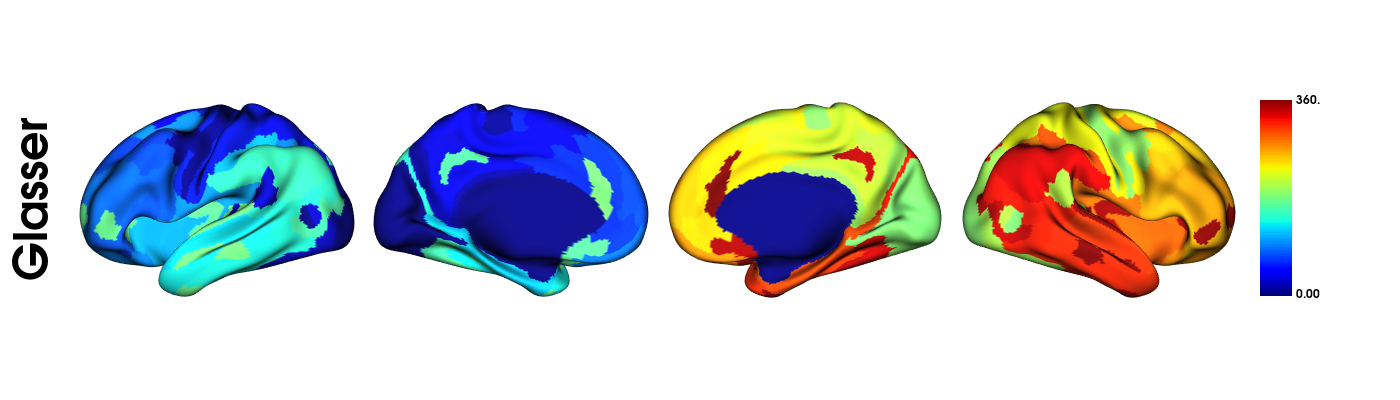

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
p_values=[]
roiOnGlasser=(glasser_fslr32k==9999999)*0
merged_data_with_res=merged_data.join(df_res) 
columns_of_interest=df_res.columns
#columns_of_interest = [col for col in df_res.columns if "FOP4" in col or "AAIC" in col or "PI" in col]  

# Effectuer un test t de Student et afficher les boxplots si significatif
for col in columns_of_interest:
    indice_R_TE2p = glasser360_aires_list.index(col)
    print(col,indice_R_TE2p)    
    roiOnGlasser=roiOnGlasser+((glasser_fslr32k==indice_R_TE2p)*indice_R_TE2p)
        
plot_hemispheres(inflated_left_fslr32k,inflated_right_fslr32k,roiOnGlasser, color_bar=True,
        label_text=["Glasser"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)